In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [4]:
with h5py.File("../Results/attacks_patches_ep10_lb4_num50_patchsize025.h5", "r") as F:
    idx = F['attack_successful'][()]
    gt_all = F['ground_truth'][()]
    gt = gt_all[idx]
    sinabs_out = F['sinabs_label'][()]
    spk_orig = F['n_spikes_orig'][idx]
    spk_attk = F['n_spikes_attk'][idx]
    print(F.keys())

<KeysViewHDF5 ['attack_successful', 'attacked_spiketrains', 'attacked_spiketrains_random', 'ground_truth', 'n_spikes_attk', 'n_spikes_orig', 'original_spiketrains', 'random_patch_successful_rate', 'sinabs_label', 'targeted_patch_successful_rate']>


In [5]:
report = np.loadtxt("../Results/report_ep10_lb4_num50_patchsize0.025.csv", skiprows=1, delimiter=",")

(
    _, gt2, chip_out, sim_out,
    chip_out_attacked_targeted, chip_out_attacked_random,
    sim_out_attacked_targeted, sim_out_attacked_random
) = report.T

assert np.all(gt == gt2)
assert len(gt) == len(spk_orig) == len(spk_attk)

In [6]:
print("Fraction of cases where sinabs got the right label:", (sinabs_out == gt_all).mean())
print("Fraction of successful attacks:", idx.mean())

Fraction of cases where sinabs got the right label: 0.9
Fraction of successful attacks: 0.9


In [15]:
class_labels = [
    "Hand Clap",
    "RH Wave",
    "LH Wave",
    "RH CW",
    "RH CCW",
    "LH CW",
    "LH CCW",
    "Arm Roll",
    "Air Drums",
    "Air Guitar",
    "Other",
]
# class_labels = ["-"]

# video

In [22]:
from aermanager.preprocess import create_raster_from_xytp

fps = 25
slowdown = 10
T = 0.2 # 200 ms
pause = 10
dt = 1000000/fps/slowdown
length = int(slowdown*fps*T)
bins = np.arange(129)

F = h5py.File("../Results/attacks_patches_ep10_lb4_num50_patchsize025.h5", "r")
N = 20
orig, attk = np.zeros((2, N*(length+pause), 128, 128))
orig_labels, attk_labels = [], []

attacked_IDs = sorted([int(k) for k in F['attacked_spiketrains'].keys()])

i = 0
for j, k in enumerate(attacked_IDs):
    if i >= N: break

    if chip_out[j] != 4 and chip_out_attacked_targeted[j] == 4:        
        spk_orig = F['original_spiketrains'][str(k)][()]
        spk_attk = F['attacked_spiketrains'][str(k)][()]
        orig_labels.append(chip_out[j])
        attk_labels.append(chip_out_attacked_targeted[j])

        start = i*(length+pause)

        raster_orig = create_raster_from_xytp(spk_orig, dt=dt, bins_x=bins, bins_y=bins)
        orig[start:start+length] = raster_orig[:, 1] - raster_orig[:, 0]
        raster_attk = create_raster_from_xytp(spk_attk, dt=dt, bins_x=bins, bins_y=bins)
        attk[start:start+length] = raster_attk[:, 1] - raster_attk[:, 0]
    
        i += 1

F.close()

6.0 4.0
3.0 4.0
3.0 4.0
7.0 4.0
6.0 4.0
9.0 4.0
7.0 4.0
10.0 4.0
9.0 4.0
3.0 4.0
3.0 4.0
3.0 4.0
6.0 4.0
7.0 4.0
7.0 4.0
1.0 4.0
6.0 4.0
3.0 4.0
1.0 4.0
6.0 4.0


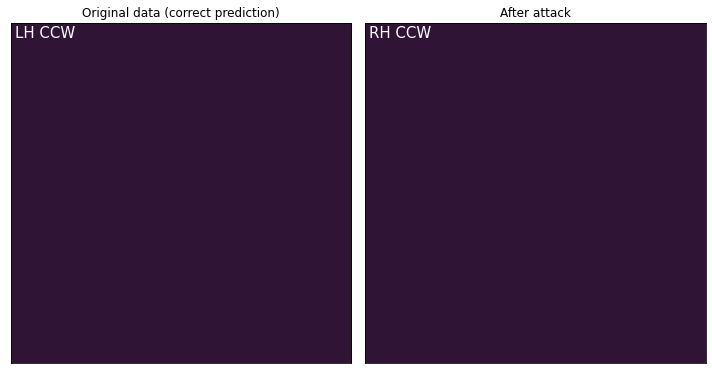

In [23]:
from matplotlib import animation

fig, ax = plt.subplots(1,2, figsize=(10, 5.5))

MAX = 3 

im = ax[0].imshow(
    np.zeros((128, 128)),
    interpolation='none',
    vmin=-MAX, vmax=MAX,
    cmap=plt.cm.twilight
)
ax[0].set_xticks([])
ax[0].set_yticks([])
im2 = ax[1].imshow(
    np.zeros((128, 128)),
    interpolation='none',
    vmin=-MAX, vmax=MAX,
    cmap=plt.cm.twilight
)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].set_title("Original data (correct prediction)")
ax[1].set_title("After attack")

t = ax[0].text(1, 5, "Prediction:", c='white', size=15)
t2 = ax[1].text(1, 5, "Prediction:", c='white', size=15)

# initialization function: plot the background of each frame
def init():
    im.set_data(np.zeros((128, 128)))
    im2.set_data(np.zeros((128, 128)))
    
    return [im]

# animation function.  This is called sequentially
def animate(i):
    im.set_array(orig[i])
    im2.set_array(attk[i])
    
    orig_label = class_labels[int(orig_labels[i // (length + pause)])]
    attk_label = class_labels[int(attk_labels[i // (length + pause)])]
    t.set_text(orig_label)
    t2.set_text(attk_label)
    return [im]
      
fig.tight_layout()
anim = animation.FuncAnimation(fig, animate, init_func=init,
               frames=len(orig), blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('patches_animation.mp4', fps=fps, dpi=150, extra_args=['-vcodec', 'libx264'])


plt.show()

# static figure

In [104]:
k = '0'
N_cols = 5
N_rows = 1
sample_len_ms = 200
dt = sample_len_ms / N_cols * 1000
bins = np.arange(129)

with h5py.File("../Results/attacks_patches_ep10_lb4_num50_patchsize025.h5", "r") as F:
    spk_orig = F['original_spiketrains'][k][()]
    spk_attk = F['attacked_spiketrains'][k][()]
    
    raster_orig = create_raster_from_xytp(spk_orig, dt=dt, bins_x=bins, bins_y=bins).sum(1)
    raster_attk = create_raster_from_xytp(spk_attk, dt=dt, bins_x=bins, bins_y=bins).sum(1)
    raster_diff = raster_attk - raster_orig

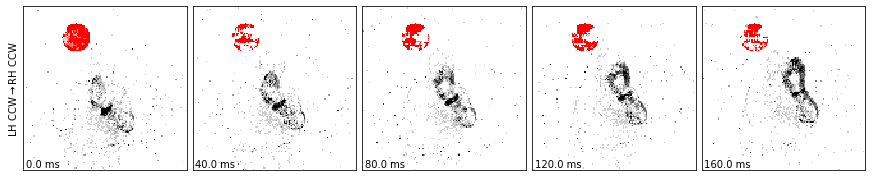

In [112]:
import matplotlib as mpl

colors = [(1., 0., 0., 0.0), (1., 0., 0., 1.0)]
nodes = [0, 1]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "transparent_red", list(zip(nodes, colors)))

fig = plt.figure(constrained_layout=True, figsize=(12, 4.7))
spec = mpl.gridspec.GridSpec(ncols=N_cols, nrows=N_rows, figure=fig)
axes = [fig.add_subplot(spec[i, j]) for i in range(N_rows) for j in range(N_cols)]
time_labels = ["%.1f ms" % (dt*i/1000) for i in range(len(axes))]


for i, ax in enumerate(axes):
    ax.set_aspect("equal")
    ax.tick_params(axis='both',
                   which='both',
                   bottom=False,
                   top=False,
                   labelbottom=False,
                   right=False,
                   left=False,
                   labelleft=False)
    
    ax.pcolormesh(raster_orig[i][::-1], vmin=0, vmax=5, cmap=plt.cm.gray_r)
    ax.pcolormesh(raster_diff[i][::-1], vmin=0, vmax=5, cmap=cmap)
    ax.text(2, 2, time_labels[i])

i = 0 # i and k are not the same thing, determining this manually, sorry
label_orig = class_labels[int(chip_out[i])]
label_attk = class_labels[int(chip_out_attacked_targeted[i])]
axes[0].set_ylabel(fr"{label_orig}$\rightarrow${label_attk}")

plt.savefig("patches_sample.png", bbox_inches='tight')